In [37]:
# Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
from tqdm import tqdm
import warnings
import gc
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sklearn
from sklearn.preprocessing import StandardScaler

# Set random seeds
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("✅ Setup complete")

Using device: cpu
✅ Setup complete


In [38]:
# Path Configuration
# Directory structure: root/data/raw, root/data/processed, root/data/splits

# Determine root path (adjust if notebook is in a subfolder like 'notebooks/')
ROOT_PATH = Path("..")  # Change to Path("..") if notebook is in notebooks/ folder

# Data paths
DATA_PATH = ROOT_PATH / "data"
RAW_DATA_PATH = DATA_PATH / "raw"
PROCESSED_DATA_PATH = DATA_PATH / "processed"
SPLITS_DATA_PATH = DATA_PATH / "splits"

# Create directories if they don't exist
PROCESSED_DATA_PATH.mkdir(exist_ok=True, parents=True)
SPLITS_DATA_PATH.mkdir(exist_ok=True, parents=True)

print("📁 Directory Structure:")
print(f"  ROOT: {ROOT_PATH.absolute()}")
print(f"  DATA: {DATA_PATH.absolute()}")
print(f"  RAW:  {RAW_DATA_PATH.absolute()}")
print(f"  PROCESSED: {PROCESSED_DATA_PATH.absolute()}")
print(f"  SPLITS: {SPLITS_DATA_PATH.absolute()}")

# Verify paths exist
print("\n🔍 Checking directories...")
print(f"  DATA exists: {DATA_PATH.exists()}")
print(f"  RAW exists: {RAW_DATA_PATH.exists()}")
print(f"  PROCESSED exists: {PROCESSED_DATA_PATH.exists()}")
print(f"  SPLITS exists: {SPLITS_DATA_PATH.exists()}")

📁 Directory Structure:
  ROOT: c:\Users\jrzem\Downloads\NFL-Big-Data-Bowl-2026-Analytics-Challenge\notebooks\..
  DATA: c:\Users\jrzem\Downloads\NFL-Big-Data-Bowl-2026-Analytics-Challenge\notebooks\..\data
  RAW:  c:\Users\jrzem\Downloads\NFL-Big-Data-Bowl-2026-Analytics-Challenge\notebooks\..\data\raw
  PROCESSED: c:\Users\jrzem\Downloads\NFL-Big-Data-Bowl-2026-Analytics-Challenge\notebooks\..\data\processed
  SPLITS: c:\Users\jrzem\Downloads\NFL-Big-Data-Bowl-2026-Analytics-Challenge\notebooks\..\data\splits

🔍 Checking directories...
  DATA exists: True
  RAW exists: True
  PROCESSED exists: True
  SPLITS exists: True


In [39]:
# Discover Available Data Files

print("🔍 Scanning for data files...")

# Check raw data
input_files = sorted(RAW_DATA_PATH.glob("input_2023_w*.csv"))
output_files = sorted(RAW_DATA_PATH.glob("output_2023_w*.csv"))
supp_file = RAW_DATA_PATH / "supplementary_data.csv"

print(f"\n📂 Raw Data ({RAW_DATA_PATH}):")
print(f"  Input files: {len(input_files)}")
print(f"  Output files: {len(output_files)}")
print(f"  Supplementary file exists: {supp_file.exists()}")

# Check processed data
parquet_files = sorted(PROCESSED_DATA_PATH.glob("features_enhanced_w*.parquet"))
print(f"\n📂 Processed Data ({PROCESSED_DATA_PATH}):")
print(f"  Parquet files: {len(parquet_files)}")

# Extract available weeks from input files
available_weeks = []
for f in input_files:
    week_str = f.stem.split('_w')[-1]
    try:
        available_weeks.append(int(week_str))
    except ValueError:
        pass

available_weeks = sorted(set(available_weeks))
print(f"\n📅 Available weeks: {available_weeks}")
print(f"   Total weeks: {len(available_weeks)}")

if not available_weeks:
    raise FileNotFoundError(
        f"No input files found in {RAW_DATA_PATH}. "
        "Please ensure input_2023_w*.csv files are in data/raw/"
    )

🔍 Scanning for data files...

📂 Raw Data (..\data\raw):
  Input files: 18
  Output files: 18
  Supplementary file exists: True

📂 Processed Data (..\data\processed):
  Parquet files: 18

📅 Available weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
   Total weeks: 18


In [40]:
# Define Train/Validation Split

# Use last 4 weeks for validation
if len(available_weeks) > 4:
    VAL_WEEKS = available_weeks[-4:]
    TRAIN_WEEKS = available_weeks[:-4]
else:
    # Fallback for fewer weeks
    split_idx = max(1, int(len(available_weeks) * 0.8))
    TRAIN_WEEKS = available_weeks[:split_idx]
    VAL_WEEKS = available_weeks[split_idx:]

print("📊 Train/Validation Split:")
print(f"  TRAIN_WEEKS: {TRAIN_WEEKS} ({len(TRAIN_WEEKS)} weeks)")
print(f"  VAL_WEEKS: {VAL_WEEKS} ({len(VAL_WEEKS)} weeks)")

# Save split info
split_info = {
    'train_weeks': TRAIN_WEEKS,
    'val_weeks': VAL_WEEKS,
    'all_weeks': available_weeks
}
with open(SPLITS_DATA_PATH / "week_splits.json", 'w') as f:
    json.dump(split_info, f, indent=2)
print(f"\n✅ Split info saved to {SPLITS_DATA_PATH / 'week_splits.json'}")

📊 Train/Validation Split:
  TRAIN_WEEKS: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] (14 weeks)
  VAL_WEEKS: [15, 16, 17, 18] (4 weeks)

✅ Split info saved to ..\data\splits\week_splits.json


In [41]:
# Memory-Efficient Dataset Class

class NFLTrajectoryDatasetLite(Dataset):
    """
    Memory-efficient dataset for 16GB RAM systems.
    - Pre-indexes all plays across weeks
    - Loads only necessary data per __getitem__ call
    - Uses basic tracking features to minimize memory
    """
    def __init__(
        self,
        weeks,
        raw_data_path,
        max_input_frames=30,
        max_output_frames=25,
        max_players=22,
        normalize=True,
        augment=False,
    ):
        self.weeks = weeks
        self.raw_data_path = Path(raw_data_path)
        self.max_input_frames = max_input_frames
        self.max_output_frames = max_output_frames
        self.max_players = max_players
        self.normalize = normalize
        self.augment = augment
        
        print(f"\n📂 Initializing dataset for weeks: {weeks}")
        
        # Build play index
        self.play_index = []
        self._build_play_index()
        
        # Define feature columns
        self.feature_cols = ['x', 'y', 's', 'a', 'dir', 'o']
        
        # Compute normalization stats
        if self.normalize:
            self._compute_normalization_stats()
        else:
            self.feature_means = np.zeros(len(self.feature_cols))
            self.feature_stds = np.ones(len(self.feature_cols))
        
        # Role/side mappings
        self.role_map = {
            "Passer": 0,
            "Targeted Receiver": 1,
            "Other Route Runner": 2,
            "Defensive Coverage": 3,
        }
        self.side_map = {"Offense": 0, "Defense": 1}
        
        print(f"✅ Total plays indexed: {len(self.play_index):,}")
    
    def _build_play_index(self):
        """Build lightweight index of all plays"""
        for week in self.weeks:
            input_file = self.raw_data_path / f"input_2023_w{week:02d}.csv"
            output_file = self.raw_data_path / f"output_2023_w{week:02d}.csv"
            
            if not input_file.exists():
                print(f"  ⚠️ Missing input: {input_file.name}")
                continue
            if not output_file.exists():
                print(f"  ⚠️ Missing output: {output_file.name}")
                continue
            
            # Read only identifier columns
            df = pd.read_csv(input_file, usecols=['game_id', 'play_id'])
            plays = df.drop_duplicates().values.tolist()
            
            for game_id, play_id in plays:
                self.play_index.append({
                    'week': week,
                    'game_id': int(game_id),
                    'play_id': int(play_id)
                })
            
            print(f"  ✓ Week {week:02d}: {len(plays)} plays")
            del df
            gc.collect()
    
    def _compute_normalization_stats(self):
        """Compute mean/std from a sample of data"""
        print("  Computing normalization statistics...")
        sample_data = []
        
        # Sample from first 2 weeks only to save memory
        for week in self.weeks[:2]:
            input_file = self.raw_data_path / f"input_2023_w{week:02d}.csv"
            if input_file.exists():
                df = pd.read_csv(input_file, usecols=self.feature_cols, nrows=10000)
                sample_data.append(df)
        
        if sample_data:
            combined = pd.concat(sample_data, ignore_index=True)
            self.feature_means = combined.mean().values.astype(np.float32)
            self.feature_stds = combined.std().values.astype(np.float32)
            self.feature_stds[self.feature_stds == 0] = 1.0
            del combined
        else:
            self.feature_means = np.zeros(len(self.feature_cols), dtype=np.float32)
            self.feature_stds = np.ones(len(self.feature_cols), dtype=np.float32)
        
        del sample_data
        gc.collect()
    
    def __len__(self):
        return len(self.play_index)
    
    def __getitem__(self, idx):
        info = self.play_index[idx]
        week = info['week']
        game_id = info['game_id']
        play_id = info['play_id']
        
        # File paths
        input_file = self.raw_data_path / f"input_2023_w{week:02d}.csv"
        output_file = self.raw_data_path / f"output_2023_w{week:02d}.csv"
        
        # Load data for this play only
        input_df = pd.read_csv(input_file)
        play_input = input_df[
            (input_df['game_id'] == game_id) & 
            (input_df['play_id'] == play_id)
        ].copy()
        del input_df
        
        output_df = pd.read_csv(output_file)
        play_output = output_df[
            (output_df['game_id'] == game_id) & 
            (output_df['play_id'] == play_id)
        ].copy()
        del output_df
        
        # Get dimensions
        frames = sorted(play_input['frame_id'].unique())
        players = play_input['nfl_id'].unique()
        
        T = self.max_input_frames
        P = self.max_players
        F = len(self.feature_cols)
        T_out = self.max_output_frames
        
        # Initialize arrays
        X = np.zeros((T, P, F), dtype=np.float32)
        Y = np.zeros((P, T_out, 2), dtype=np.float32)
        mask = np.ones((T, P), dtype=bool)
        role_ids = np.zeros(P, dtype=np.int64)
        side_ids = np.zeros(P, dtype=np.int64)
        players_to_predict = np.zeros(P, dtype=bool)
        
        # Get num_frames_output
        if 'num_frames_output' in play_input.columns:
            num_out = int(play_input['num_frames_output'].iloc[0])
        else:
            num_out = 10
        num_out = min(num_out, T_out)
        
        # Build player mapping
        player_list = list(players[:P])
        player_to_idx = {p: i for i, p in enumerate(player_list)}
        
        # Fill input features
        for fi, frame in enumerate(frames[:T]):
            frame_data = play_input[play_input['frame_id'] == frame]
            for _, row in frame_data.iterrows():
                pid = row['nfl_id']
                if pid not in player_to_idx:
                    continue
                pi = player_to_idx[pid]
                
                X[fi, pi, :] = row[self.feature_cols].fillna(0).values.astype(np.float32)
                mask[fi, pi] = False
                
                if fi == 0:
                    role = row.get('player_role', 'Defensive Coverage')
                    side = row.get('player_side', 'Defense')
                    role_ids[pi] = self.role_map.get(role, 3)
                    side_ids[pi] = self.side_map.get(side, 1)
                    players_to_predict[pi] = bool(row.get('player_to_predict', False))
        
        # Fill output targets
        for _, row in play_output.iterrows():
            pid = row['nfl_id']
            if pid not in player_to_idx:
                continue
            pi = player_to_idx[pid]
            fi = int(row['frame_id']) - 1
            if 0 <= fi < T_out:
                Y[pi, fi, 0] = row['x']
                Y[pi, fi, 1] = row['y']
        
        # Normalize input
        if self.normalize:
            X = (X - self.feature_means) / (self.feature_stds + 1e-8)
        
        # Augmentation: horizontal flip
        if self.augment and np.random.rand() < 0.5:
            y_idx = self.feature_cols.index('y')
            X[:, :, y_idx] = -X[:, :, y_idx]
            Y[:, :, 1] = 53.3 - Y[:, :, 1]
        
        del play_input, play_output
        
        return {
            'input_seq': torch.from_numpy(X),
            'output_seq': torch.from_numpy(Y),
            'mask': torch.from_numpy(mask),
            'role_ids': torch.from_numpy(role_ids),
            'side_ids': torch.from_numpy(side_ids),
            'players_to_predict': torch.from_numpy(players_to_predict),
            'num_output_frames': num_out,
            'metadata': {'week': week, 'game_id': game_id, 'play_id': play_id}
        }

print("✅ Dataset class defined")

✅ Dataset class defined


In [42]:
# Transformer Model (Lite version for 16GB RAM)

class TrajectoryTransformerLite(nn.Module):
    """
    Lighter Transformer model for trajectory prediction.
    Optimized for 16GB RAM systems.
    """
    def __init__(self, 
                 input_dim=6,
                 hidden_dim=128,
                 num_heads=4,
                 num_layers=3,
                 max_players=22,
                 max_seq_len=30,
                 max_output_frames=25,
                 dropout=0.1):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.max_output_frames = max_output_frames
        
        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout)
        )
        
        # Positional encoding
        self.register_buffer('pos_encoding', 
            self._generate_positional_encoding(max_seq_len, hidden_dim))
        
        # Role and side embeddings
        self.role_embedding = nn.Embedding(5, hidden_dim)
        self.side_embedding = nn.Embedding(2, hidden_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 2,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, max_output_frames * 2)
        )
    
    def _generate_positional_encoding(self, max_len, d_model):
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return pe
    
    def forward(self, x, role_ids, side_ids, num_output_frames, mask=None):
        """
        Args:
            x: [B, T, P, F] - input sequence
            role_ids: [B, P] - player roles
            side_ids: [B, P] - player sides
            num_output_frames: list[int] - frames to predict per sample
            mask: [B, T, P] - attention mask
        Returns:
            trajectories: [B, P, max_T, 2]
        """
        B, T, P, F = x.shape
        
        # Reshape: [B*P, T, F]
        x = x.permute(0, 2, 1, 3).reshape(B * P, T, F)
        
        # Project input
        x = self.input_projection(x)
        
        # Add positional encoding
        x = x + self.pos_encoding[:, :T, :]
        
        # Add role embedding
        role_emb = self.role_embedding(role_ids).reshape(B * P, 1, self.hidden_dim)
        x = x + role_emb
        
        # Add side embedding
        side_emb = self.side_embedding(side_ids).reshape(B * P, 1, self.hidden_dim)
        x = x + side_emb
        
        # Reshape mask
        if mask is not None:
            mask = mask.permute(0, 2, 1).reshape(B * P, T)
        
        # Transformer encoding
        encoded = self.transformer(x, src_key_padding_mask=mask)
        
        # Use last timestep
        last_hidden = encoded[:, -1, :]
        
        # Predict trajectories
        output = self.output_head(last_hidden)
        output = output.reshape(B, P, self.max_output_frames, 2)
        
        return output

print("✅ Model class defined")

✅ Model class defined


In [43]:
# Collate Function and DataLoader Creation

def collate_fn(batch):
    """Custom collate that handles metadata and variable-length outputs"""
    out = {}
    for key in batch[0].keys():
        if key == 'metadata':
            out[key] = [sample[key] for sample in batch]
        elif key == 'num_output_frames':
            out[key] = [sample[key] for sample in batch]
        else:
            out[key] = torch.stack([sample[key] for sample in batch])
    return out

# Create datasets
print("Creating training dataset...")
train_dataset = NFLTrajectoryDatasetLite(
    weeks=TRAIN_WEEKS,
    raw_data_path=RAW_DATA_PATH,
    normalize=True,
    augment=True,
)

print("\nCreating validation dataset...")
val_dataset = NFLTrajectoryDatasetLite(
    weeks=VAL_WEEKS,
    raw_data_path=RAW_DATA_PATH,
    normalize=True,
    augment=False,
)

# Small batch size for 16GB RAM
BATCH_SIZE = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,  # Required for Windows
    pin_memory=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
)

print(f"\n{'='*50}")
print("📊 Dataset Summary")
print(f"{'='*50}")
print(f"Training plays:   {len(train_dataset):,}")
print(f"Validation plays: {len(val_dataset):,}")
print(f"Batch size:       {BATCH_SIZE}")
print(f"Training batches: {len(train_loader):,}")
print(f"Val batches:      {len(val_loader):,}")
print(f"Features:         {train_dataset.feature_cols}")
print(f"{'='*50}")

Creating training dataset...

📂 Initializing dataset for weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  ✓ Week 01: 819 plays
  ✓ Week 02: 850 plays
  ✓ Week 03: 904 plays
  ✓ Week 04: 779 plays
  ✓ Week 05: 742 plays
  ✓ Week 06: 793 plays
  ✓ Week 07: 693 plays
  ✓ Week 08: 827 plays
  ✓ Week 09: 711 plays
  ✓ Week 10: 721 plays
  ✓ Week 11: 707 plays
  ✓ Week 12: 854 plays
  ✓ Week 13: 666 plays
  ✓ Week 14: 796 plays
  Computing normalization statistics...
✅ Total plays indexed: 10,862

Creating validation dataset...

📂 Initializing dataset for weeks: [15, 16, 17, 18]
  ✓ Week 15: 791 plays
  ✓ Week 16: 896 plays
  ✓ Week 17: 809 plays
  ✓ Week 18: 750 plays
  Computing normalization statistics...
✅ Total plays indexed: 3,246

📊 Dataset Summary
Training plays:   10,862
Validation plays: 3,246
Batch size:       2
Training batches: 5,431
Val batches:      1,623
Features:         ['x', 'y', 's', 'a', 'dir', 'o']


In [44]:
# Optional: Subsample datasets for faster prototyping
MAX_TRAIN_PLAYS = 300   # try 200–500 to start
MAX_VAL_PLAYS = 100

import random

def subset_dataset(dataset, max_plays, name="train"):
    if len(dataset) <= max_plays:
        print(f"{name} dataset has {len(dataset)} plays (≤ {max_plays}), no subsampling.")
        return dataset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    keep = sorted(indices[:max_plays])
    dataset.play_index = [dataset.play_index[i] for i in keep]
    print(f"{name} dataset subsampled: {len(keep)} plays kept.")
    return dataset

train_dataset = subset_dataset(train_dataset, MAX_TRAIN_PLAYS, name="train")
val_dataset = subset_dataset(val_dataset, MAX_VAL_PLAYS, name="val")

train dataset subsampled: 300 plays kept.
val dataset subsampled: 100 plays kept.


In [45]:
# Test Data Loading

print("🧪 Testing data loading...")

try:
    batch = next(iter(train_loader))
    
    print("✅ Batch loaded successfully!\n")
    print("Tensor shapes:")
    print(f"  input_seq:          {batch['input_seq'].shape}")
    print(f"  output_seq:         {batch['output_seq'].shape}")
    print(f"  mask:               {batch['mask'].shape}")
    print(f"  role_ids:           {batch['role_ids'].shape}")
    print(f"  side_ids:           {batch['side_ids'].shape}")
    print(f"  players_to_predict: {batch['players_to_predict'].shape}")
    print(f"  num_output_frames:  {batch['num_output_frames']}")
    
    # Check targets have values
    target_sum = batch['output_seq'].abs().sum().item()
    print(f"\n📊 Target data check:")
    print(f"  Target abs sum: {target_sum:.2f} (should be > 0)")
    
    # Check players to predict
    ptp_count = batch['players_to_predict'].sum().item()
    print(f"  Players to predict: {ptp_count}")
    
    print(f"\n📋 Sample metadata: {batch['metadata'][0]}")
    
except Exception as e:
    print(f"❌ Error loading batch: {e}")
    import traceback
    traceback.print_exc()

🧪 Testing data loading...
✅ Batch loaded successfully!

Tensor shapes:
  input_seq:          torch.Size([2, 30, 22, 6])
  output_seq:         torch.Size([2, 22, 25, 2])
  mask:               torch.Size([2, 30, 22])
  role_ids:           torch.Size([2, 22])
  side_ids:           torch.Size([2, 22])
  players_to_predict: torch.Size([2, 22])
  num_output_frames:  [6, 13]

📊 Target data check:
  Target abs sum: 36944.71 (should be > 0)
  Players to predict: 7

📋 Sample metadata: {'week': 5, 'game_id': 2023100805, 'play_id': 2836}


In [46]:
# Training Functions

def train_epoch(model, loader, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    num_batches = 0
    
    pbar = tqdm(loader, desc="Training")
    for batch in pbar:
        input_seq = batch['input_seq'].to(device)
        output_seq = batch['output_seq'].to(device)
        mask = batch['mask'].to(device)
        role_ids = batch['role_ids'].to(device)
        side_ids = batch['side_ids'].to(device)
        players_to_predict = batch['players_to_predict'].to(device)
        num_output_frames = batch['num_output_frames']
        
        optimizer.zero_grad()
        
        # Forward pass
        pred = model(input_seq, role_ids, side_ids, num_output_frames, mask)
        
        # Compute loss only for players_to_predict
        loss = 0
        count = 0
        for b in range(pred.shape[0]):
            T = num_output_frames[b]
            pmask = players_to_predict[b]
            if pmask.sum() > 0:
                pred_b = pred[b, pmask, :T, :]
                target_b = output_seq[b, pmask, :T, :]
                loss += F.mse_loss(pred_b, target_b)
                count += 1
        
        if count > 0:
            loss = loss / count
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Memory cleanup
        del input_seq, output_seq, mask, pred
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    return total_loss / max(num_batches, 1)


def validate_epoch(model, loader, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            input_seq = batch['input_seq'].to(device)
            output_seq = batch['output_seq'].to(device)
            mask = batch['mask'].to(device)
            role_ids = batch['role_ids'].to(device)
            side_ids = batch['side_ids'].to(device)
            players_to_predict = batch['players_to_predict'].to(device)
            num_output_frames = batch['num_output_frames']
            
            pred = model(input_seq, role_ids, side_ids, num_output_frames, mask)
            
            loss = 0
            count = 0
            for b in range(pred.shape[0]):
                T = num_output_frames[b]
                pmask = players_to_predict[b]
                if pmask.sum() > 0:
                    pred_b = pred[b, pmask, :T, :]
                    target_b = output_seq[b, pmask, :T, :]
                    loss += F.mse_loss(pred_b, target_b)
                    count += 1
            
            if count > 0:
                total_loss += (loss / count).item()
                num_batches += 1
            
            del input_seq, output_seq, mask, pred
    
    return total_loss / max(num_batches, 1)

print("✅ Training functions defined")

✅ Training functions defined


In [47]:
# Initialize Model

# Model configuration (more lightweight for faster training)
model_config = {
    'input_dim': len(train_dataset.feature_cols),
    'hidden_dim': 96,          # ↓ from 128
    'num_heads': 3,            # ↓ from 4 (must divide hidden_dim)
    'num_layers': 2,           # ↓ from 3
    'max_players': 16,         # ↓ from 22 (clips less-used players)
    'max_seq_len': 24,         # ↓ from 30
    'max_output_frames': 20,   # ↓ from 25
    'dropout': 0.1
}

print("🏗️ Model Configuration:")
for k, v in model_config.items():
    print(f"  {k}: {v}")

# Update dataset limits to match model (optional but safer)
train_dataset.max_players = model_config['max_players']
val_dataset.max_players = model_config['max_players']
train_dataset.max_input_frames = model_config['max_seq_len']
val_dataset.max_input_frames = model_config['max_seq_len']
train_dataset.max_output_frames = model_config['max_output_frames']
val_dataset.max_output_frames = model_config['max_output_frames']

# Initialize model
model = TrajectoryTransformerLite(**model_config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size (approx):  {total_params * 4 / 1024 / 1024:.2f} MB")

🏗️ Model Configuration:
  input_dim: 6
  hidden_dim: 96
  num_heads: 3
  num_layers: 2
  max_players: 16
  max_seq_len: 24
  max_output_frames: 20
  dropout: 0.1

📊 Model Statistics:
  Total parameters:     164,296
  Trainable parameters: 164,296
  Model size (approx):  0.63 MB


In [48]:
# Training Loop (shorter & more aggressive stopping)

# Hyperparameters
NUM_EPOCHS = 12            # ↓ from 20
LEARNING_RATE = 3e-4       # ↑ a bit for faster convergence
WEIGHT_DECAY = 1e-4        # slight regularization

# Optimizer and scheduler (no verbose arg in new PyTorch)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training history
history = {'train_loss': [], 'val_loss': [], 'lr': []}
best_val_loss = float('inf')
patience_counter = 0
MAX_PATIENCE = 4          # ↓ from 7

print(f"\n{'='*60}")
print("🚀 Starting Training")
print(f"{'='*60}")
print(f"Epochs (max): {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Device: {device}")
print(f"{'='*60}\n")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*50}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, device)
    
    # Validate
    val_loss = validate_epoch(model, val_loader, device)
    
    # Get LR before update
    old_lr = optimizer.param_groups[0]['lr']
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # LR after update
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(current_lr)
    
    print(f"\n📊 Results:")
    print(f"  Train Loss: {train_loss:.6f}")
    print(f"  Val Loss:   {val_loss:.6f}")
    print(f"  LR:         {current_lr:.2e}")
    
    if current_lr < old_lr:
        print(f"  📉 LR reduced: {old_lr:.2e} → {current_lr:.2e}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss,
            'config': model_config,
            'feature_cols': train_dataset.feature_cols,
            'feature_means': train_dataset.feature_means.tolist(),
            'feature_stds': train_dataset.feature_stds.tolist(),
        }, PROCESSED_DATA_PATH / 'best_model.pth')
        
        print(f"  ✅ New best model saved!")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{MAX_PATIENCE})")
    
    # Early stopping
    if patience_counter >= MAX_PATIENCE:
        print(f"\n⚠️ Early stopping at epoch {epoch}")
        break
    
    # Memory cleanup
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("✅ Training Complete!")
print(f"{'='*60}")
print(f"Best Validation Loss: {best_val_loss:.6f}")


🚀 Starting Training
Epochs (max): 12
Learning Rate: 0.0003
Device: cpu


Epoch 1/12


Validating: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]



📊 Results:
  Train Loss: 2190.689783
  Val Loss:   1584.110110
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 2/12


Validating: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]



📊 Results:
  Train Loss: 961.490690
  Val Loss:   469.521625
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 3/12


Validating: 100%|██████████| 50/50 [00:44<00:00,  1.14it/s]



📊 Results:
  Train Loss: 391.643879
  Val Loss:   202.657422
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 4/12


Validating: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]



📊 Results:
  Train Loss: 195.938835
  Val Loss:   156.246254
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 5/12


Validating: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]



📊 Results:
  Train Loss: 162.901115
  Val Loss:   145.655807
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 6/12


Validating: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]



📊 Results:
  Train Loss: 144.361546
  Val Loss:   160.287427
  LR:         3.00e-04
  No improvement (1/4)

Epoch 7/12


Validating: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]



📊 Results:
  Train Loss: 130.505621
  Val Loss:   102.402895
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 8/12


Validating: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]



📊 Results:
  Train Loss: 90.014915
  Val Loss:   59.988106
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 9/12


Validating: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s]



📊 Results:
  Train Loss: 68.436459
  Val Loss:   45.476757
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 10/12


Validating: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]



📊 Results:
  Train Loss: 55.754651
  Val Loss:   65.845976
  LR:         3.00e-04
  No improvement (1/4)

Epoch 11/12


Validating: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]



📊 Results:
  Train Loss: 55.330328
  Val Loss:   34.182650
  LR:         3.00e-04
  ✅ New best model saved!

Epoch 12/12


Validating: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


📊 Results:
  Train Loss: 50.010405
  Val Loss:   30.689530
  LR:         3.00e-04
  ✅ New best model saved!

✅ Training Complete!
Best Validation Loss: 30.689530


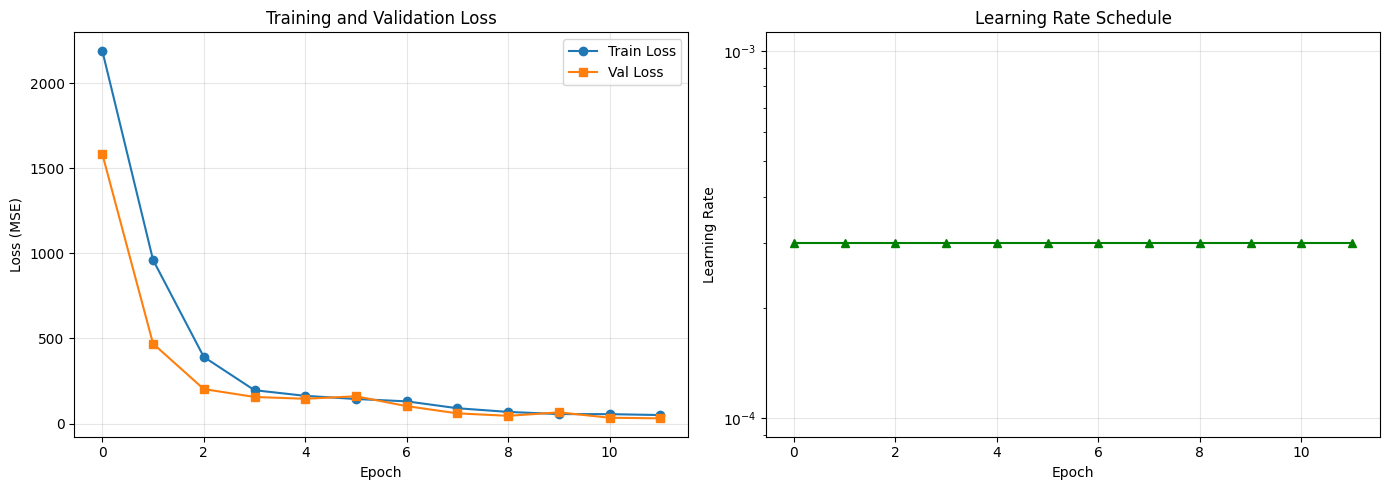

✅ Plot saved to ..\data\processed\training_history.png


In [49]:
# Plot Training History

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate plot
axes[1].plot(history['lr'], label='Learning Rate', color='green', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROCESSED_DATA_PATH / 'training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved to {PROCESSED_DATA_PATH / 'training_history.png'}")

In [50]:
# Evaluation Metrics

def compute_metrics(model, loader, device):
    """Compute ADE and FDE metrics"""
    model.eval()
    
    all_ade = []
    all_fde = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Computing metrics"):
            input_seq = batch['input_seq'].to(device)
            output_seq = batch['output_seq'].to(device)
            mask = batch['mask'].to(device)
            role_ids = batch['role_ids'].to(device)
            side_ids = batch['side_ids'].to(device)
            players_to_predict = batch['players_to_predict']
            num_output_frames = batch['num_output_frames']
            
            pred = model(input_seq, role_ids, side_ids, num_output_frames, mask)
            
            for b in range(pred.shape[0]):
                T = num_output_frames[b]
                pmask = players_to_predict[b]
                
                if pmask.sum() == 0:
                    continue
                
                pred_b = pred[b, pmask, :T, :].cpu()
                target_b = output_seq[b, pmask, :T, :].cpu()
                
                # Displacement errors
                displacements = torch.sqrt(((pred_b - target_b) ** 2).sum(dim=-1))
                
                # ADE: average over all frames
                ade = displacements.mean().item()
                all_ade.append(ade)
                
                # FDE: error at final frame
                fde = displacements[:, -1].mean().item()
                all_fde.append(fde)
            
            del input_seq, output_seq, pred
    
    return {
        'ADE_mean': np.mean(all_ade),
        'ADE_std': np.std(all_ade),
        'FDE_mean': np.mean(all_fde),
        'FDE_std': np.std(all_fde),
    }

# Load best model
checkpoint = torch.load(PROCESSED_DATA_PATH / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Compute metrics
print("\n📊 Computing evaluation metrics...")
metrics = compute_metrics(model, val_loader, device)

print(f"\n{'='*60}")
print("📊 EVALUATION METRICS")
print(f"{'='*60}")
print(f"Average Displacement Error (ADE): {metrics['ADE_mean']:.4f} ± {metrics['ADE_std']:.4f} yards")
print(f"Final Displacement Error (FDE):   {metrics['FDE_mean']:.4f} ± {metrics['FDE_std']:.4f} yards")
print(f"{'='*60}")

Loaded best model from epoch 12

📊 Computing evaluation metrics...


Computing metrics: 100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


📊 EVALUATION METRICS
Average Displacement Error (ADE): 6.3182 ± 3.6215 yards
Final Displacement Error (FDE):   8.7277 ± 6.0206 yards


🎨 Creating visualizations...


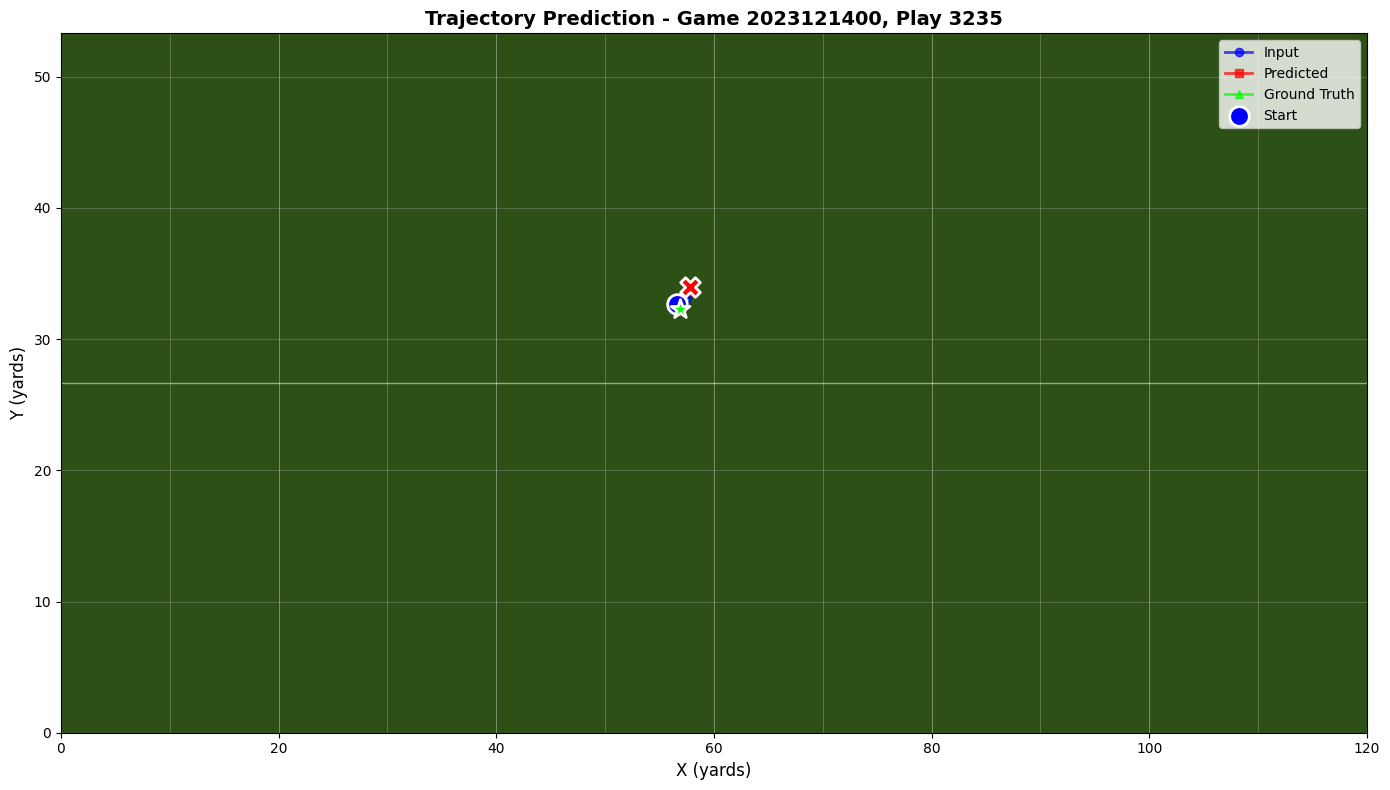

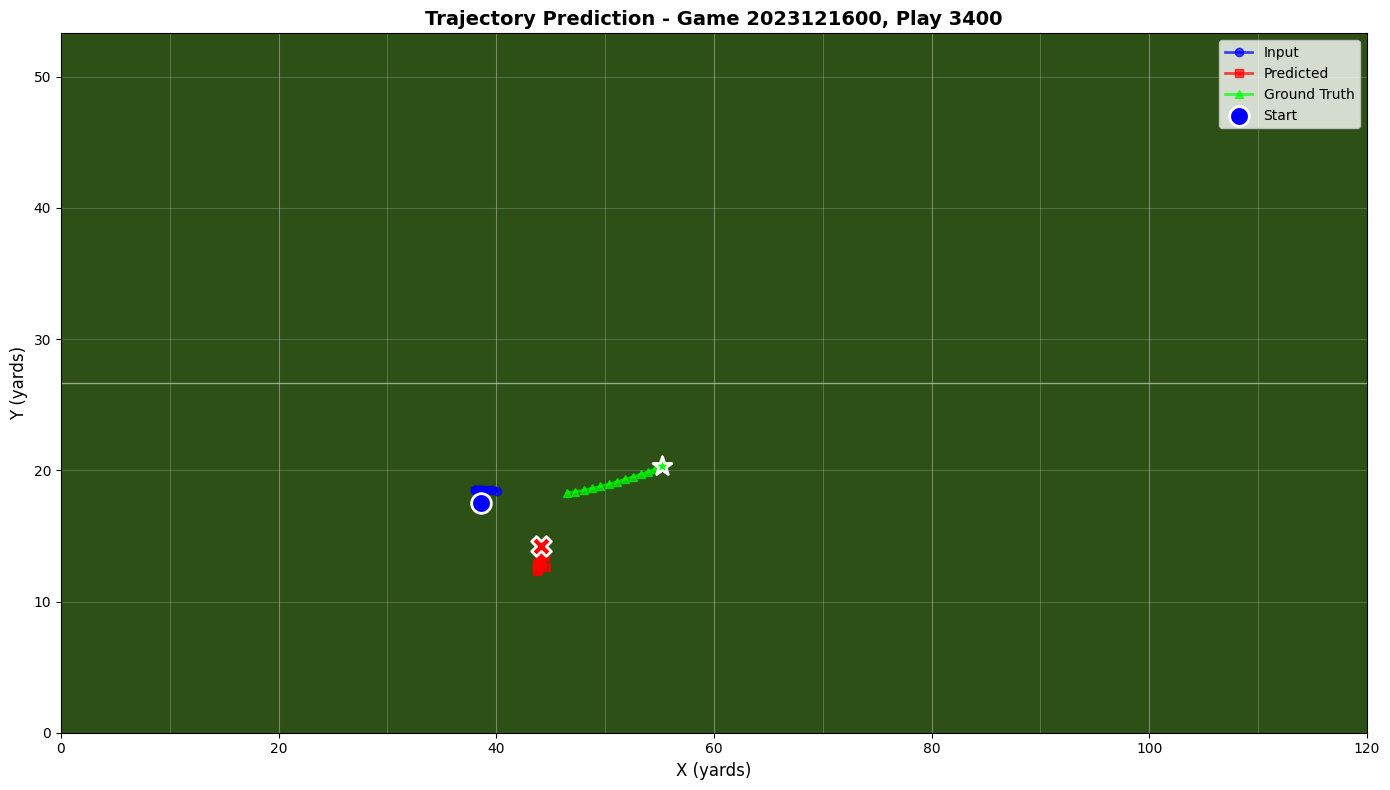

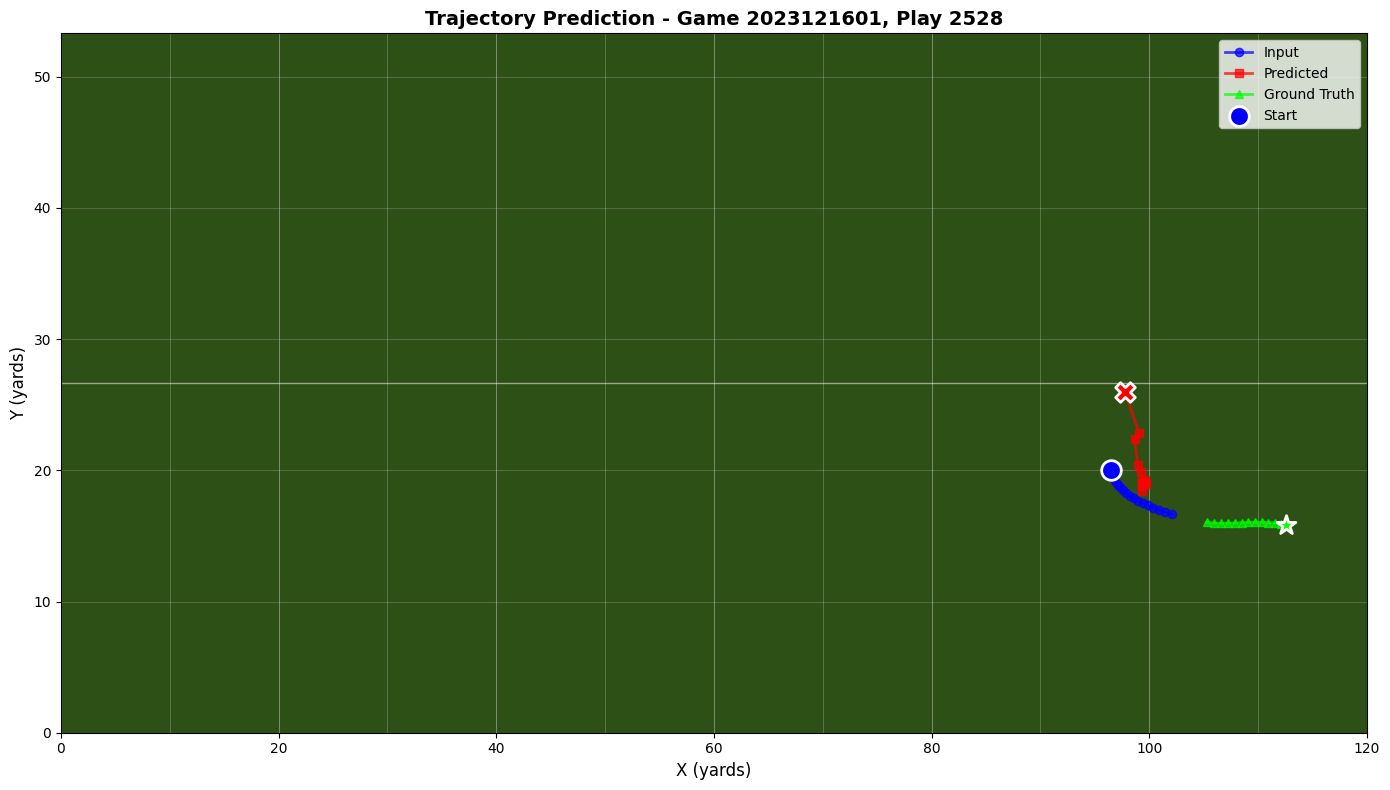

✅ Visualizations saved to ..\data\processed


In [51]:
# Visualize Sample Predictions

def visualize_prediction(model, dataset, idx, device):
    """Visualize a single prediction"""
    model.eval()
    
    sample = dataset[idx]
    
    # Prepare batch of 1
    input_seq = sample['input_seq'].unsqueeze(0).to(device)
    output_seq = sample['output_seq']
    mask = sample['mask'].unsqueeze(0).to(device)
    role_ids = sample['role_ids'].unsqueeze(0).to(device)
    side_ids = sample['side_ids'].unsqueeze(0).to(device)
    players_to_predict = sample['players_to_predict']
    num_output_frames = [sample['num_output_frames']]
    metadata = sample['metadata']
    
    with torch.no_grad():
        pred = model(input_seq, role_ids, side_ids, num_output_frames, mask)
    
    pred = pred[0].cpu()
    
    # Find a player to predict
    ptp_indices = torch.where(players_to_predict)[0]
    if len(ptp_indices) == 0:
        print("No players to predict in this sample")
        return None
    
    player_idx = ptp_indices[0].item()
    T = num_output_frames[0]
    
    # Get trajectories
    pred_traj = pred[player_idx, :T, :].numpy()
    target_traj = output_seq[player_idx, :T, :].numpy()
    
    # Denormalize input for visualization
    input_data = sample['input_seq'][:, player_idx, :].numpy()
    means = dataset.feature_means
    stds = dataset.feature_stds
    input_denorm = input_data * stds + means
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Field boundaries
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_facecolor('#2d5016')
    
    # Field lines
    for x in range(0, 121, 10):
        ax.axvline(x, color='white', linewidth=0.5, alpha=0.3)
    ax.axhline(53.3/2, color='white', linewidth=1, alpha=0.5)
    
    # Input trajectory (x, y are first two features)
    valid_frames = ~sample['mask'][:, player_idx].numpy()
    input_x = input_denorm[valid_frames, 0]
    input_y = input_denorm[valid_frames, 1]
    ax.plot(input_x, input_y, 'o-', color='blue', linewidth=2, 
            markersize=6, label='Input', alpha=0.7)
    
    # Predicted trajectory
    ax.plot(pred_traj[:, 0], pred_traj[:, 1], 's-', color='red', 
            linewidth=2, markersize=6, label='Predicted', alpha=0.7)
    
    # Ground truth trajectory
    ax.plot(target_traj[:, 0], target_traj[:, 1], '^-', color='lime', 
            linewidth=2, markersize=6, label='Ground Truth', alpha=0.7)
    
    # Start/end markers
    ax.scatter(input_x[0], input_y[0], s=200, c='blue', marker='o', 
               edgecolors='white', linewidths=2, zorder=5, label='Start')
    ax.scatter(target_traj[-1, 0], target_traj[-1, 1], s=200, c='lime', 
               marker='*', edgecolors='white', linewidths=2, zorder=5)
    ax.scatter(pred_traj[-1, 0], pred_traj[-1, 1], s=200, c='red', 
               marker='X', edgecolors='white', linewidths=2, zorder=5)
    
    ax.set_xlabel('X (yards)', fontsize=12)
    ax.set_ylabel('Y (yards)', fontsize=12)
    ax.set_title(f"Trajectory Prediction - Game {metadata['game_id']}, Play {metadata['play_id']}", 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Visualize a few samples
print("🎨 Creating visualizations...")

for i in range(min(3, len(val_dataset))):
    fig = visualize_prediction(model, val_dataset, i, device)
    if fig:
        fig.savefig(PROCESSED_DATA_PATH / f'prediction_sample_{i}.png', dpi=150, bbox_inches='tight')
        plt.show()
        plt.close(fig)

print(f"✅ Visualizations saved to {PROCESSED_DATA_PATH}")

In [52]:
# Save Final Artifacts

# Save final model with all metadata
final_save_path = PROCESSED_DATA_PATH / 'final_model_complete.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': model_config,
    'feature_cols': train_dataset.feature_cols,
    'feature_means': train_dataset.feature_means.tolist(),
    'feature_stds': train_dataset.feature_stds.tolist(),
    'history': history,
    'metrics': metrics,
    'train_weeks': TRAIN_WEEKS,
    'val_weeks': VAL_WEEKS,
}, final_save_path)

# Save training history
with open(PROCESSED_DATA_PATH / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# Save metrics
with open(PROCESSED_DATA_PATH / 'evaluation_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

# Save normalization stats
norm_stats = {
    'feature_cols': train_dataset.feature_cols,
    'feature_means': train_dataset.feature_means.tolist(),
    'feature_stds': train_dataset.feature_stds.tolist(),
}
with open(PROCESSED_DATA_PATH / 'normalization_stats.json', 'w') as f:
    json.dump(norm_stats, f, indent=2)

print(f"\n{'='*60}")
print("✅ ALL ARTIFACTS SAVED")
print(f"{'='*60}")
print(f"\n📁 Saved to {PROCESSED_DATA_PATH}:")
print(f"  - final_model_complete.pth")
print(f"  - best_model.pth")
print(f"  - training_history.json")
print(f"  - training_history.png")
print(f"  - evaluation_metrics.json")
print(f"  - normalization_stats.json")
print(f"  - prediction_sample_*.png")
print(f"\n{'='*60}")
print("🎉 Modeling notebook complete!")
print(f"{'='*60}")


✅ ALL ARTIFACTS SAVED

📁 Saved to ..\data\processed:
  - final_model_complete.pth
  - best_model.pth
  - training_history.json
  - training_history.png
  - evaluation_metrics.json
  - normalization_stats.json
  - prediction_sample_*.png

🎉 Modeling notebook complete!
